# Nucleosome Positioning Analysis Tool (NuCTOOL) 2.0

In [92]:
import re
import numpy as np
from scipy.special import erf
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm

In [93]:
FOOTPRINT = 147
OCCUPANCY_KERNEL = 146

_ASCII_TO_IDX = np.full(256, -1, dtype=np.int8)
_ASCII_TO_IDX[ord("A")] = 0
_ASCII_TO_IDX[ord("C")] = 1
_ASCII_TO_IDX[ord("G")] = 2
_ASCII_TO_IDX[ord("T")] = 3


@dataclass(frozen=True)
class NucPositionResult:
    energy: np.ndarray
    dyad_probability: np.ndarray
    occupancy: np.ndarray


# all function to simulate nucleosome positioning and methylation


def clean_sequence(dna: str) -> str:
    """Remove non-GATC characters to prevent energy calculation errors."""
    dna = dna.upper().replace("U", "T")
    return re.sub(r"[^GATC]", "", dna)


def encode_seq(seq: str) -> np.ndarray:
    """Convert sequence string to numeric indices for vectorized computation."""
    b = np.frombuffer(seq.encode("ascii"), dtype=np.uint8)
    return _ASCII_TO_IDX[b]


def get_weight(w: int, period: float, amplitude: float) -> np.ndarray:
    """Generate periodic dinucleotide weights to model DNA bendability."""
    x = np.arange(w, dtype=np.float64) - w//2
    s = amplitude * np.cos(2 * np.pi * x / period)
    weights = np.empty((4, 4, w), dtype=np.float64)
    weights[0, 0] = 0.25 + s
    weights[0, 1] = 0.25 - s / 3
    weights[0, 2] = 0.25 - s / 3
    weights[0, 3] = 0.25 - s / 3
    weights[1, 0] = 0.25
    weights[1, 1] = 0.25
    weights[1, 2] = 0.25
    weights[1, 3] = 0.25
    weights[2, 0] = 0.25 + s / 3
    weights[2, 1] = 0.25 - s
    weights[2, 2] = 0.25 + s / 3
    weights[2, 3] = 0.25 + s / 3
    weights[3, 0] = 0.25 + s
    weights[3, 1] = 0.25 - s
    weights[3, 2] = 0.25 - s
    weights[3, 3] = 0.25 + s
    return weights


def calculate_energy(seq: str, width: int, amplitude: float, period: float) -> np.ndarray:
    """Compute energy landscape by accounting for both forward and reverse strand binding."""
    idx = encode_seq(seq)
    L = idx.size
    num_win = L - width
    if num_win <= 0:
        return np.array([], dtype=np.float64)
    weights = get_weight(width, period, amplitude)
    log_weights = np.log(np.clip(weights, 1e-300, None))
    log_p_f = np.zeros(num_win, dtype=np.float64)
    log_p_r = np.zeros(num_win, dtype=np.float64)
    i = np.arange(num_win) -FOOTPRINT//2
    for s in range(width):
        if s > 0:
            prev_f = idx[i + s - 1]
        else:
            prev_f = idx[i + s]
        curr_f = idx[i + s]
        log_p_f += log_weights[prev_f, curr_f, s]
        a = idx[i + width - s]
        b = idx[i + width - s - 1]
        rprev = 3 - a
        rcurr = 3 - b
        log_p_r += log_weights[rprev, rcurr, s]
    p_f = np.exp(log_p_f) * (4.0**width)
    p_r = np.exp(log_p_r) * (4.0**width)
    p_r = np.roll(p_r, -1)
    E = (p_r * np.log(p_r) + p_f * np.log(p_f)) / (p_r + p_f)
    energy = np.concatenate( (E, np.zeros(width)))
    return energy


def compute_vanderlick(Energy: np.ndarray, mu: float, footprint: int) -> np.ndarray:
    """Compute equilibrium dyad probability accounting for steric exclusion between nucleosomes."""
    E_out = Energy - mu
    n = E_out.size
    forward = np.zeros(n, dtype=np.float64)
    sum_prev = 0.0
    for i in range(n):
        forward[i] = np.exp(E_out[i] - sum_prev)
        sum_prev += forward[i]
        if i >= footprint:
            sum_prev -= forward[i - footprint]
    backward = np.zeros(n, dtype=np.float64)
    r_forward = forward[::-1]
    sum_prod = 0.0
    for i in range(n):
        backward[i] = 1.0 - sum_prod
        sum_prod += r_forward[i] * backward[i]
        if i >= footprint:
            sum_prod -= r_forward[i - footprint] * backward[i - footprint]
    return forward * backward[::-1]


def calc_nuc_positions(
    sequence: str, w: int, chemical_potential: float, amplitude: float, period: float
) -> NucPositionResult:
    """Pipeline combining all steps to generate final nucleosome positioning prediction."""
    sequence = clean_sequence(sequence)
    energy = calculate_energy(sequence, w, amplitude, period)
    dyad_probability = compute_vanderlick(energy, chemical_potential, w)
    dyad_probability = np.clip(dyad_probability, 0, np.inf)
    occupancy = np.convolve(
        dyad_probability, np.ones(OCCUPANCY_KERNEL, dtype=np.float64), mode="same"
    )
    occupancy = np.clip(occupancy, 0, 1)
    return NucPositionResult(energy, dyad_probability, occupancy)


def create_sequence(contour_length, dyads_601=None):
    """Generate test sequences with known positioning elements for validation."""
    sequence = np.random.choice(list("ACGT"), contour_length)

    if dyads_601 is not None:
        sequence_601 = list(
            "ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG"
        )
        for dyad in dyads_601:
            start_index = max(0, dyad - len(sequence_601) // 2)
            end_index = min(contour_length, dyad + len(sequence_601) // 2)
            length = end_index - start_index
            sequence[start_index : start_index + length] = sequence_601[:length]

    sequence = "".join(sequence)
    return sequence


def sample_fiber_configuration(
    dyad_probability: np.ndarray, footprint: int = FOOTPRINT
) -> np.ndarray:
    """
    Stochastically sample a single nucleosome arrangement to generate ensemble statistics.
    Edge regions are excluded to prevent boundary artifacts from biasing occupancy.
    """
    p = dyad_probability.copy()
    nucs = np.zeros_like(dyad_probability)
    dyads = []

    num_nucleosomes = np.random.poisson(lam=np.sum(dyad_probability))
    
    half_footprint = footprint // 2
    seq_length = len(dyad_probability)

    for _ in range(int(num_nucleosomes)):
        if p.sum() < 0.5:
            break
        # Sample a dyad position
        dyads.append(np.random.choice(seq_length, p=p / p.sum()))

        nuc_start = dyads[-1] - half_footprint
        nuc_end = nuc_start + footprint

        nucs[nuc_start:nuc_end] = 1
        p[nuc_start:nuc_end] = 0

    return dyads, nucs


def calc_methylation(sequence, dyads, sigma=15, efficiency=0.85):
    dyads = np.array(dyads)
    footprint = FOOTPRINT - 2 * sigma
    unprotected = [
        np.prod(
            0.5 * (1 + erf((np.abs(dyads - i) - footprint / 2) / (sigma * np.sqrt(2))))
        )
        for i in range(len(sequence))
    ]
    targets = np.array([1 if base in "AT" else 0 for base in sequence])
    methylated = np.random.binomial(1, np.asarray(unprotected) * targets * efficiency)
    return methylated


def plot_profiles(
    dyads=None, dyad_probability=None, occupancy=None, nucs=None, methylation=None
):
    """Visualize multiple layers of positioning data for comparison."""
    plt.figure(figsize=(15, 2.5))
    xmax = 0
    if dyads is not None:
        plt.vlines(
            dyads,
            0,
            1.5,
            colors="grey",
            linestyles="dashed",
            label="601 Dyads",
            alpha=0.5,
        )
    if dyad_probability is not None:
        plt.plot(dyad_probability * 1e1, label="Dyads", color="red")
        xmax = len(dyad_probability)
    if occupancy is not None:
        plt.plot(occupancy, label="Occupancy", color="blue")
        xmax = len(occupancy)
    if nucs is not None:
        x = np.arange(len(nucs))
        plt.fill_between(x, 0, nucs, alpha=0.1, color="blue", label="Nucleosomes")
        xmax = len(nucs)
    if methylation is not None:
        x = np.arange(len(methylation))
        plt.scatter(
            x[methylation == 1],
            0.5 * methylation[methylation == 1],
            marker="o",
            alpha=0.3,
            facecolors="none",
            edgecolors="green",
            linewidths=0.5,
            color="green",
            label="Methylation",
        )
        xmax = len(methylation)

    plt.xlabel("i (bp)")
    plt.ylabel("Probability")
    plt.legend(loc="upper right", framealpha=1, facecolor="white")
    plt.ylim(-0.1, 1.1)
    plt.xlim(0, xmax)
    plt.tight_layout()


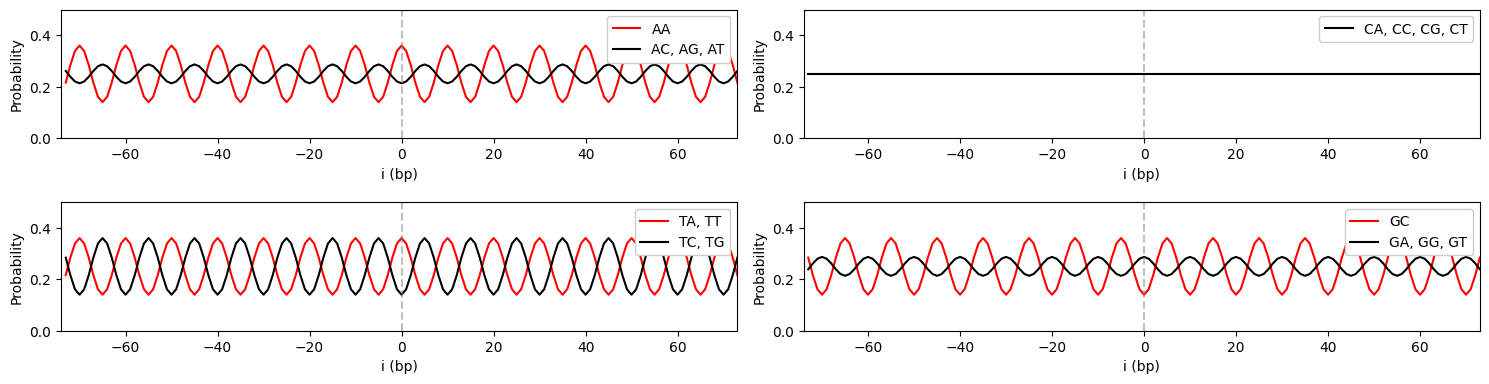

In [94]:
# Display weights for dinucleotide combinations in nucleosomes

weight = get_weight(FOOTPRINT, period=10.0, amplitude=0.11)
x= np.arange(FOOTPRINT)-FOOTPRINT//2

fig, axes = plt.subplots(2, 2, figsize=(15, 4))
axes = axes.flatten()

for idx, base1 in enumerate("ACTG"):
    ax = axes[idx]
    label2 = ""
    base2 = "A"
    w1 = weight[*encode_seq(base1 + base2)]
    w2 = -np.ones_like(w1)
    label1 = base1 + base2
    for base2 in "CGT":
        width = weight[*encode_seq(base1 + base2)]
        if np.array_equal(width,w1):
            label1 += ", " + base1 + base2
        else:
            w2 = width
            if label2 is None:
                label2 = base1 + base2
            else:
                if len(label2) > 0:
                    label2 += ", "
                label2 += base1 + base2
    if len(label1) > len(label2):
        label1, label2 = label2, label1
        w1, w2 = w2, w1
         
    if w1 is not None:
        ax.plot(x, w1, color='red', label=label1)
    if w2 is not None:
        ax.plot(x, w2, color='black', label=label2)

    ax.axvline(0, color='grey', linestyle='dashed', alpha=0.5)
    ax.legend(loc="upper right", framealpha=1, facecolor="white")
    ax.set_xlabel("i (bp)")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 0.5)
    ax.set_xlim(-FOOTPRINT//2, FOOTPRINT//2)


plt.tight_layout()
plt.show()

In [95]:
# Generate random test sequence and add 601 elements
contour_length = 10000
handle_length = 3000
dyads_601 = np.arange(handle_length, contour_length - handle_length, 197)
sequence = create_sequence(contour_length, dyads_601)

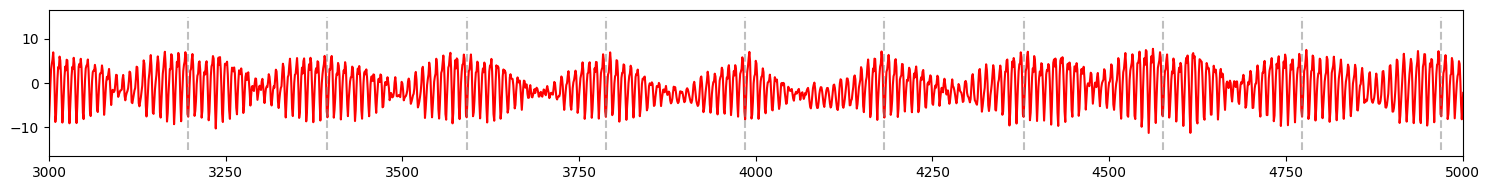

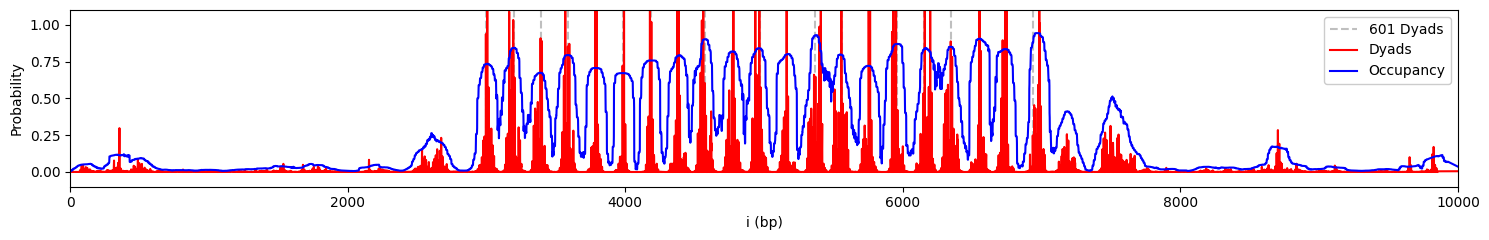

In [96]:
# Generate nucleosome occupancy according to van der Heijden et al. 2012 PNAS
# Slightly modified to avoid smoothing of energy landscape.
# Higher chemical potential and smaller amplitude required.
result = calc_nuc_positions(
    sequence, FOOTPRINT, chemical_potential=7.5, amplitude=0.11, period=9.8
)

plt.figure(figsize=(15, 2))
plt.plot(result.energy, color='red')
plt.xlim(0, len(sequence))
plt.xlim(3000, 5000)
plt.vlines(dyads_601, ymin=-15, ymax=15, colors='grey', linestyles='dashed', alpha=0.5)
plt.tight_layout()
plt.show()

plot_profiles(
    dyads=dyads_601,
    dyad_probability=result.dyad_probability,
    occupancy=result.occupancy,
)

100%|██████████| 1000/1000 [00:02<00:00, 376.28it/s]


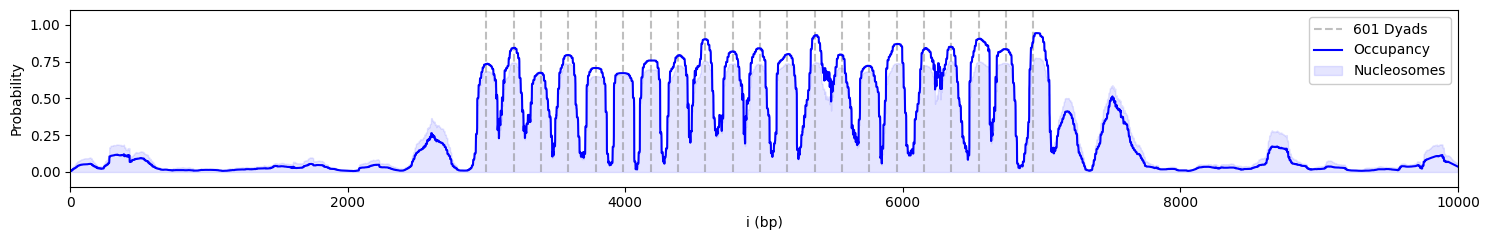

In [97]:
# Verify ensemble statistics by sampling individual configurations
# In dense regions, this yields too low occupancy due to non-equilibrium steric exclusion.
# Consequently, in sparse regions, this yields slightly higher occupancy.
nucs = np.zeros_like(result.dyad_probability)
n = 1000
for _ in tqdm(range(n)):
    nucs += sample_fiber_configuration(result.dyad_probability, FOOTPRINT)[-1]
nucs /= n

plot_profiles(dyads=dyads_601, occupancy=result.occupancy, nucs=nucs)

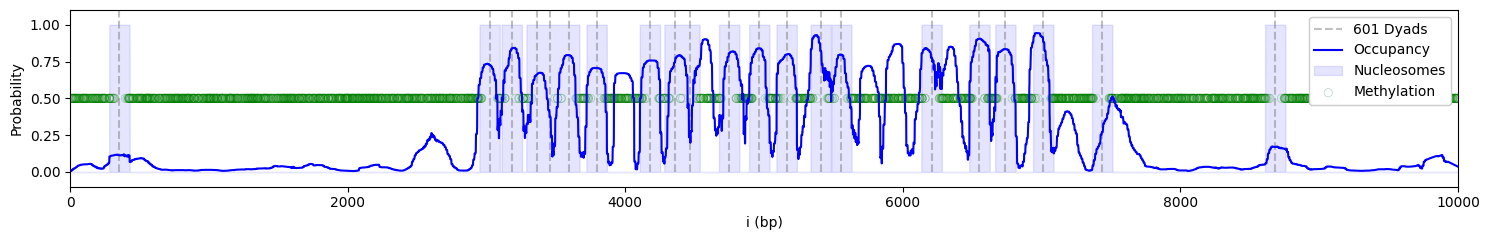

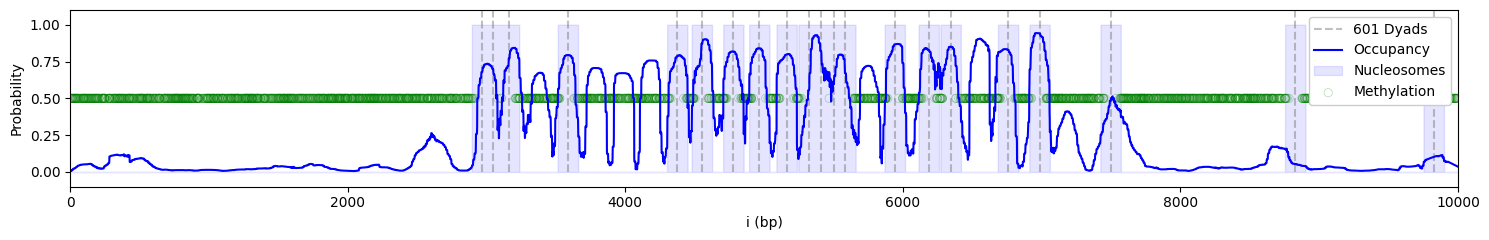

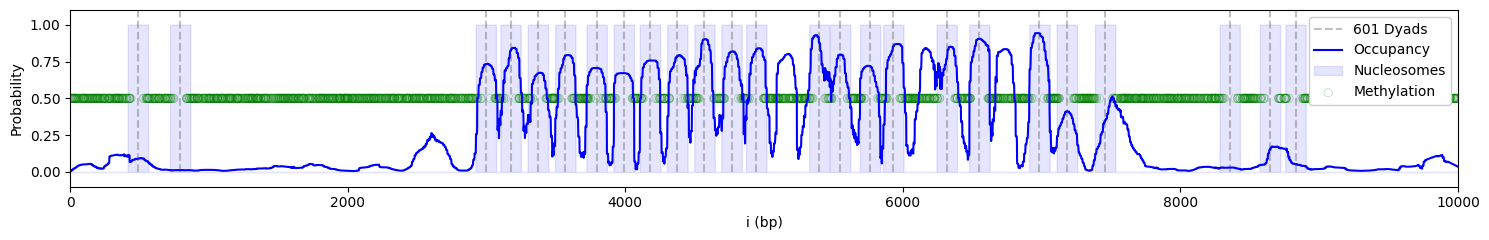

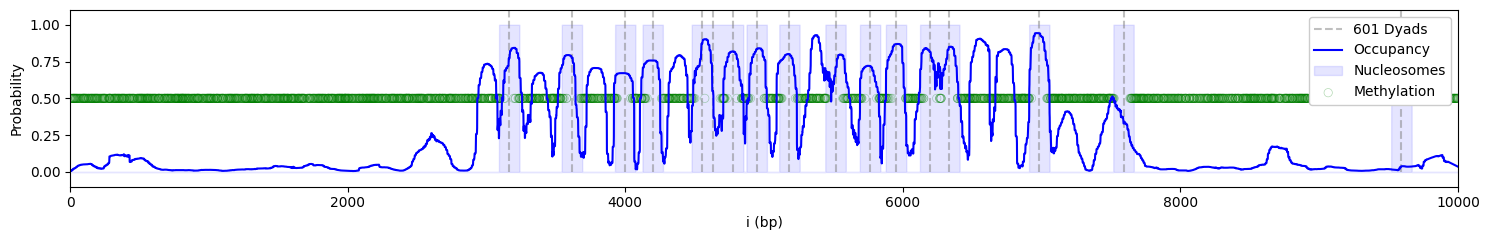

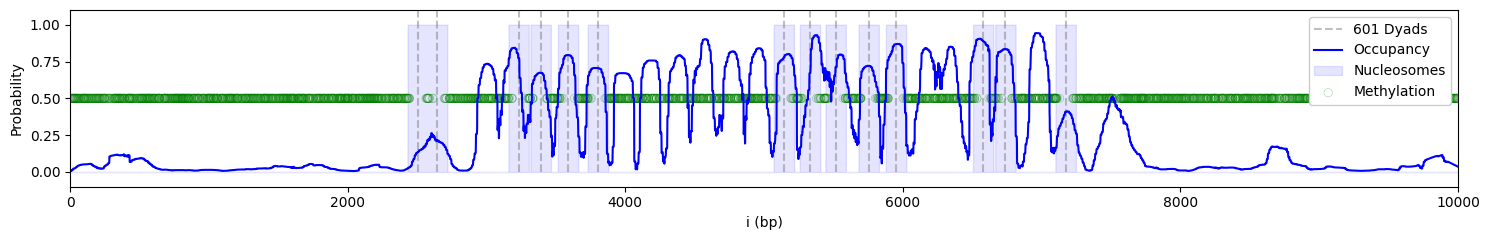

In [98]:
# Sample single fiber configuration(s) and calculate methylation profile
for _ in range(5):
    fiber_dyads, fiber_nucs = sample_fiber_configuration(result.dyad_probability, FOOTPRINT)
    methylated = calc_methylation(sequence, fiber_dyads, sigma=15, efficiency=0.85)
    plot_profiles(
        dyads=fiber_dyads,
        occupancy=result.occupancy,
        nucs=fiber_nucs,
        methylation=methylated,
    )

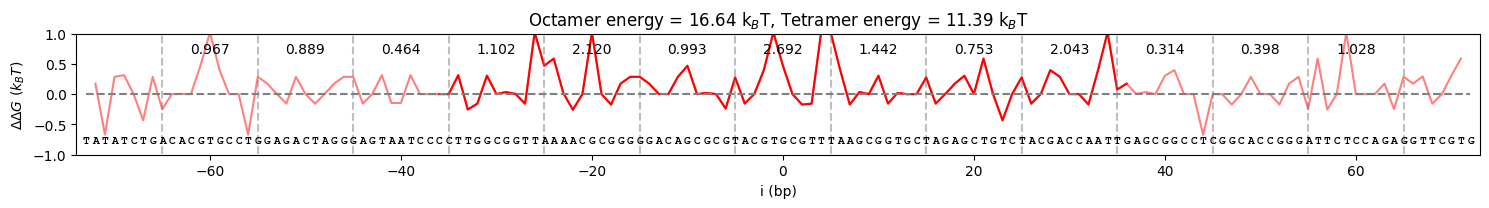

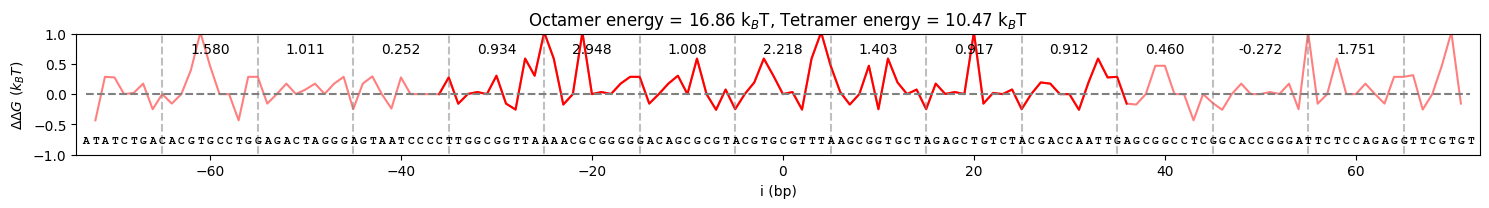

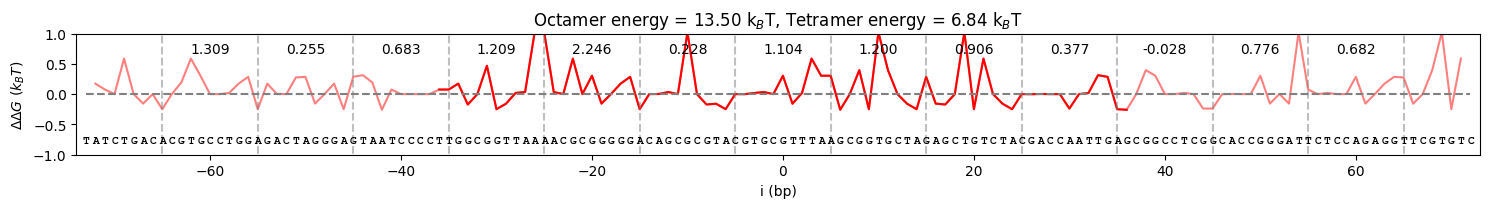

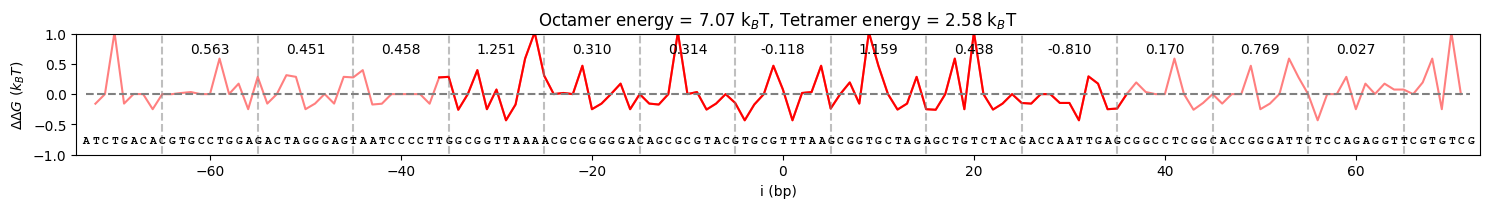

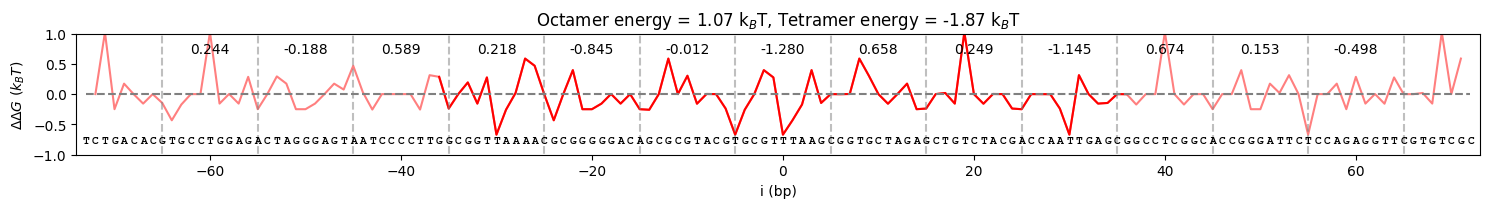

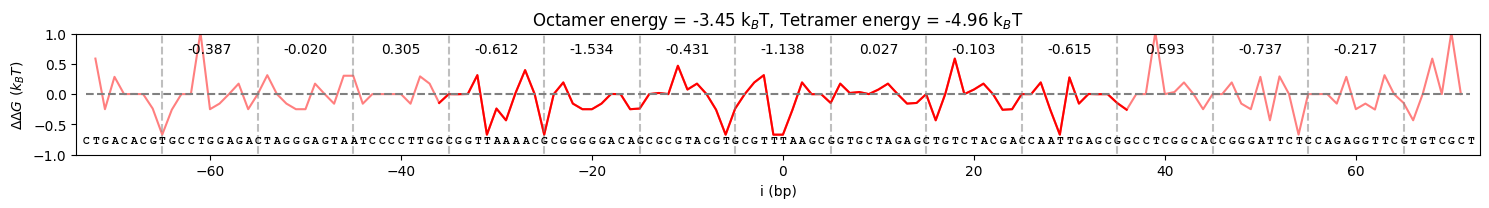

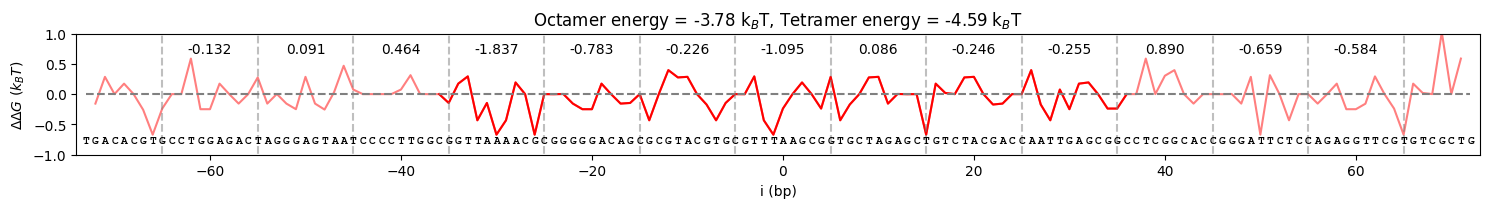

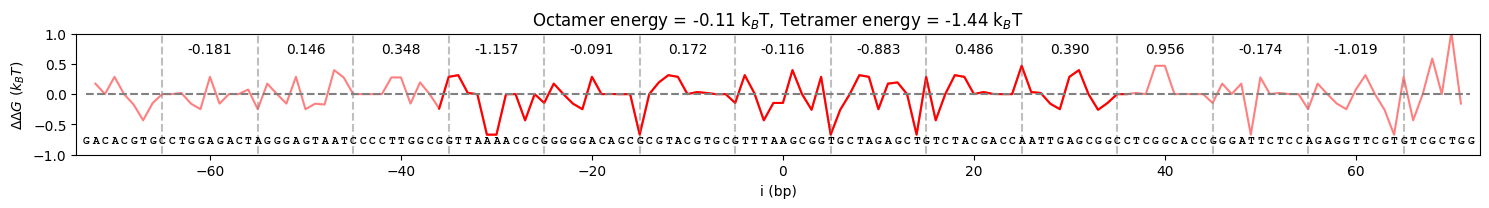

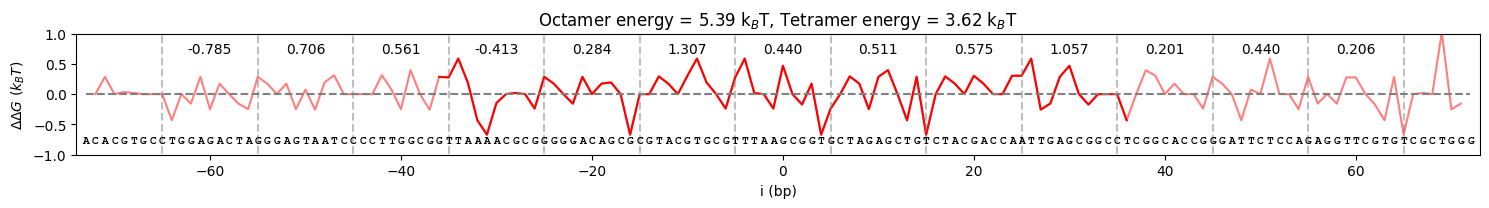

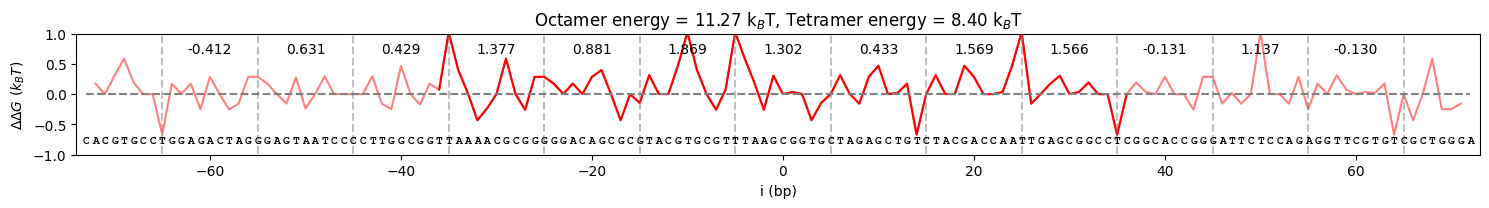

In [ ]:
# Visualize energy landscape around a single nucleosome

def calc_wrapping_energy(sequence, dyad, log_weights, show = False):
    start = -len(log_weights[0,0])//2
    end = start + len(log_weights[0,0]) +1
    
    # Extract and encode sequence segment
    seq_segment = sequence[dyad+start:dyad+end-1]
    idx = encode_seq(seq_segment)
    
    # Vectorized forward calculation
    n = len(idx) - 1
    indices = np.arange(n)
    forward = log_weights[idx[:-1], idx[1:], indices] + np.log(4.0)
    forward = np.append(forward, np.nan)
    
    # Vectorized reverse calculation
    idx_rev = idx[::-1]
    reverse = log_weights[idx_rev[:-1], idx_rev[1:], indices] + np.log(4.0)
    reverse = np.append(reverse, np.nan)[::-1]
    
    wrapping_energy = -(forward + reverse)
    
    energy_octamer = np.sum(wrapping_energy[1:-1])
    energy_tetramer = np.sum(wrapping_energy[ (np.arange(start, end-1) >= -36) & (np.arange(start, end-1) <= 36)])

    if show:
        plt.figure(figsize=(15, 2))
        x_positions = np.arange(start, end-1).astype(np.float64)
        plt.plot(x_positions, wrapping_energy, color='red', alpha=0.5)
        tetrasome = np.where( (x_positions >= -36) & (x_positions <= 36))
        plt.plot(x_positions[tetrasome], wrapping_energy[tetrasome], color='red')
        plt.hlines(0, x_positions[0], x_positions[-1], colors='gray', linestyles='dashed')
        contact_points= np.arange(-7,7)*10+5
        plt.vlines(contact_points, ymin=-10, ymax=10, colors='grey', linestyles='dashed', alpha=0.5)
        plt.ylim(-1, 1)
        plt.xlim(x_positions[0]-1, x_positions[-1]+1)

        for pos, base in zip(x_positions, seq_segment):
            plt.text(pos, -00.7, base, ha='center', va='top', fontsize=8, family='Courier New', weight='bold')

        for i, _ in enumerate(contact_points[:-1]+74):
            pos = (contact_points[i] +contact_points[i+1])/2
            selection = np.where((x_positions >= contact_points[i]) & (x_positions < contact_points[i+1]))
            segment_energy = np.sum(wrapping_energy[selection])
            plt.text(pos, 0.85, f'{segment_energy:.3f}', ha='center', va='top')


        plt.xlabel('i (bp)')
        plt.ylabel(r'$\Delta\Delta G$ ($k_B T$)')
        plt.tight_layout()
        plt.title(rf'$\Delta\Delta G_{{\mathrm{{octamer}}}}$ = {energy_octamer:.2f} $k_B T$, $\Delta\Delta G_{{\mathrm{{tetramer}}}}$ = {energy_tetramer:.2f} $k_B T$')
    return energy_octamer, energy_tetramer

log_weights = np.log(np.clip(get_weight(146, period=10.0, amplitude=0.11), 1e-300, None))

for i in range(-5,5):
    calc_wrapping_energy(sequence, fiber_dyads[5]+i, log_weights=log_weights, show=True);
